# CATS VS DOGS

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

2025-04-07 17:58:25.722352: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 17:58:25.733280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744041505.744892   51833 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744041505.748296   51833 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744041505.758414   51833 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Imprimo las primeras 9 imagenes de perros

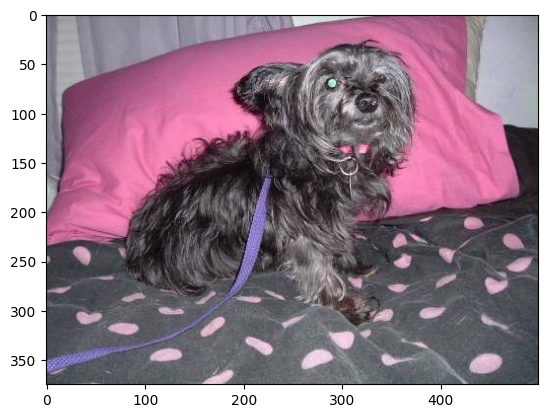

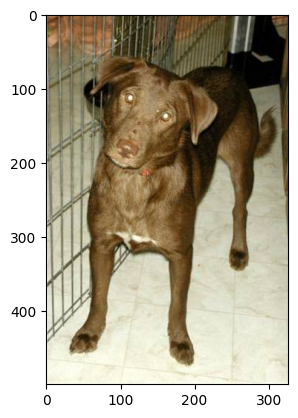

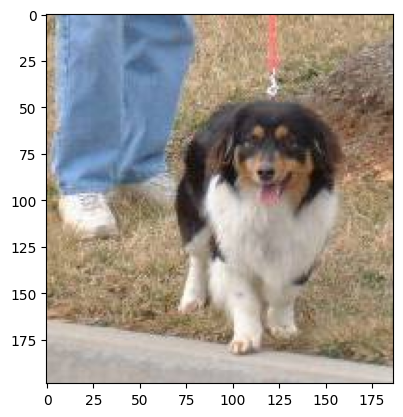

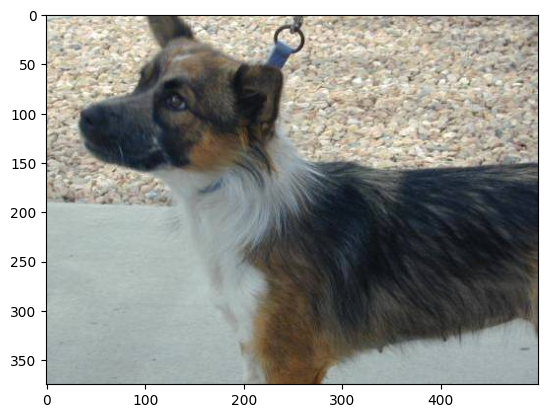

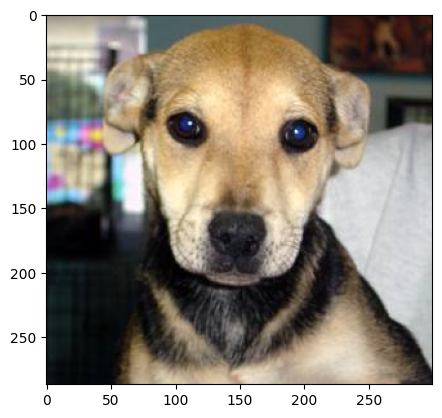

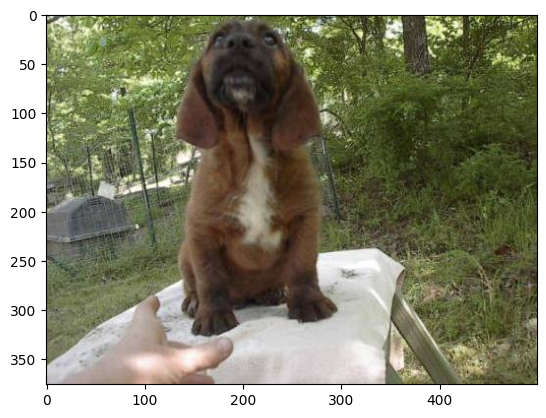

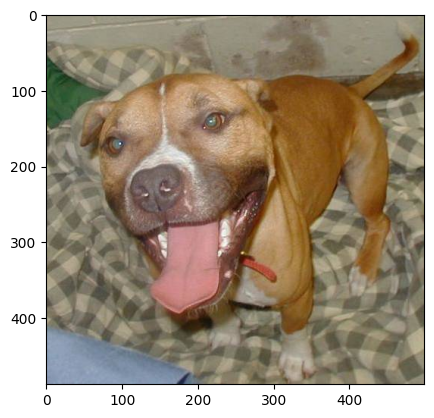

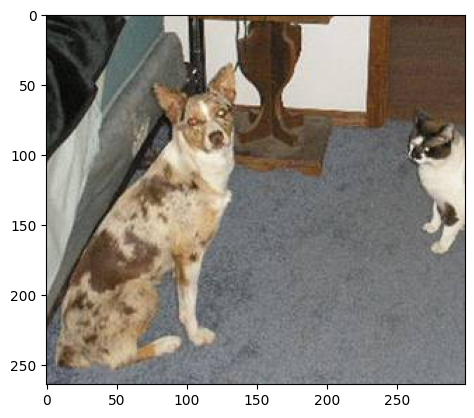

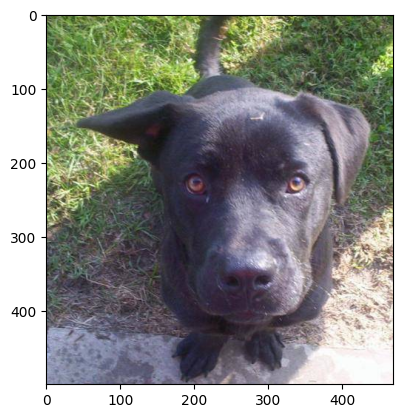

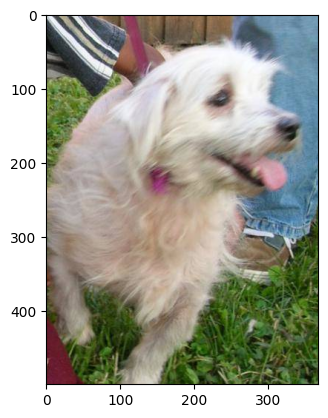

In [2]:
PATH = '../data/raw/data/'

for n in range(10):
    img=mpimg.imread(f'{PATH}/dog/dog.{n}.jpg')
    imgplot = plt.imshow(img)
    plt.show()

## Imprimo las 9 imagenes de los gatos

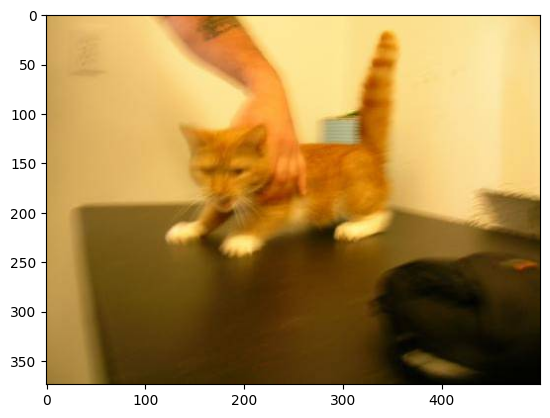

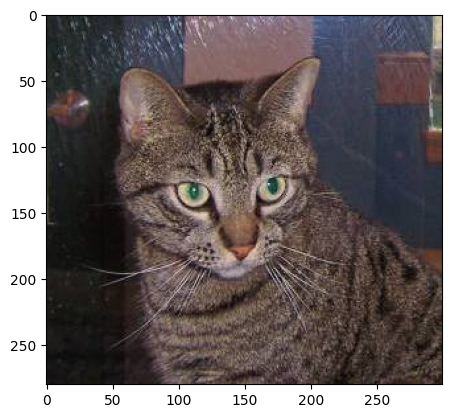

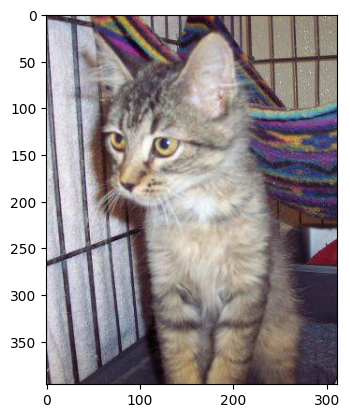

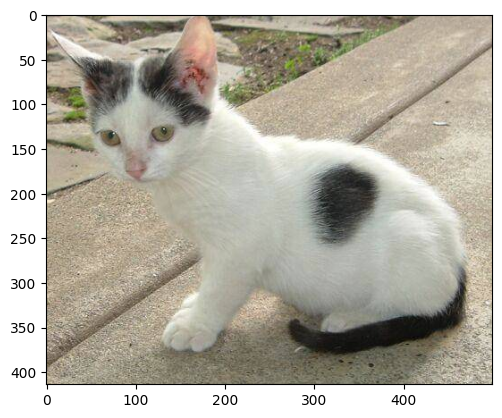

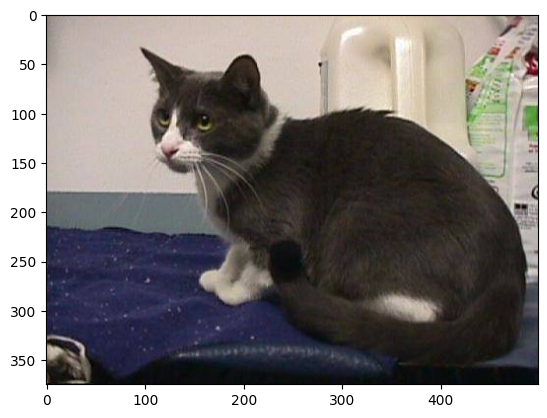

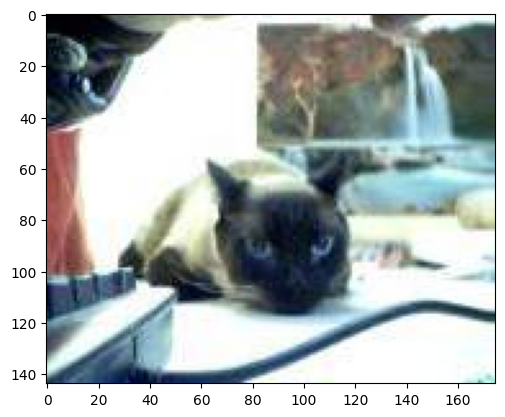

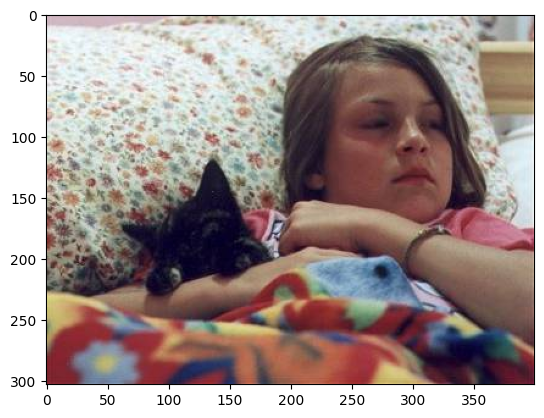

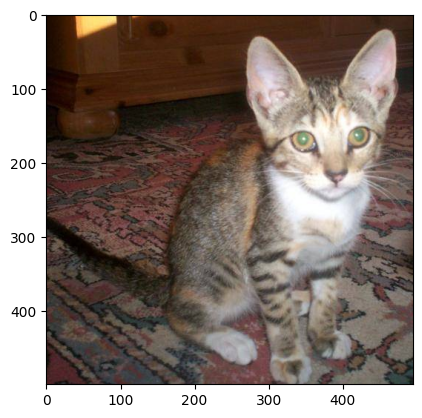

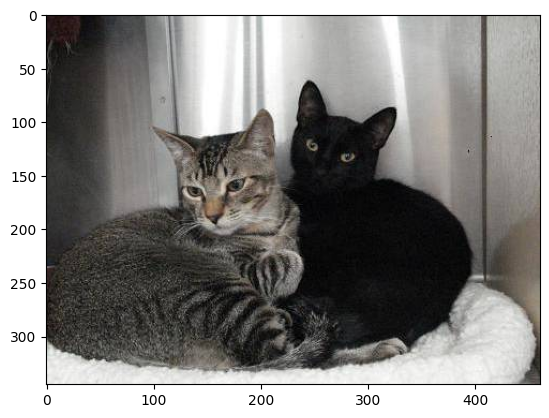

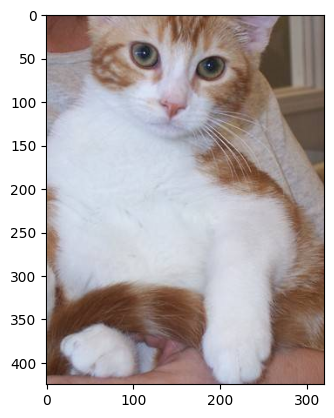

In [3]:
for n in range(10):
    img=mpimg.imread(f'{PATH}/cat/cat.{n}.jpg')
    imgplot = plt.imshow(img)
    plt.show()

## Cargo el image loader de Keras

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    directory=PATH,
    labels="inferred",        # Obtiene automáticamente las clases de las subcarpetas (cat/dog)
    label_mode="int",         # "int", "categorical" o "binary" según prefieras
    validation_split=0.2,     # Porcentaje que se separará como validación
    subset="training",        # Indica que es el subset de entrenamiento
    seed=42,                 # Fija semilla para que la separación sea reproducible
    image_size=(200, 200),    # Redimensiona todas las imágenes
    batch_size=32
)

# Conjunto de validación (20%)
val_ds = image_dataset_from_directory(
    directory=PATH,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",      # Indica que es el subset de validación
    seed=42,
    image_size=(200, 200),
    batch_size=32
)

print("Longitud train_ds:", tf.data.experimental.cardinality(train_ds).numpy())
print("Longitud val_ds:  ", tf.data.experimental.cardinality(val_ds).numpy())

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


I0000 00:00:1744041509.485041   51833 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Longitud train_ds: 625
Longitud val_ds:   157


## Normalizado y Data Augmentation

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),        # Voltea horizontalmente el 50% de las veces
    layers.RandomRotation(0.1),            # Rotación aleatoria
    layers.RandomZoom(0.1),                # Zoom aleatorio
    layers.RandomContrast(0.1),          # Contraste aleatorio, etc.
])

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))

## Divido mis imagenes en train/test


## Cargo mi modelo

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam

In [7]:
cnn_model = Sequential([
    Input(shape=(200, 200, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    Flatten(),
    Dense(units=4096, activation="relu"),
    Dense(units=4096, activation="relu"),
    Dense(units=2, activation="softmax")
])

In [ ]:
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # asumiendo labels enteros (0,1)
    metrics=['accuracy'],
    #jit_compile=False
)

In [9]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    75,501,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,005,762 (408.19 MB)

 Trainable params: 107,005,762 (408.19 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Añado early stopping ya que mi mejor epoch es el numero 7
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = cnn_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=25,
    callbacks=[early_stop]
)

Epoch 1/25


I0000 00:00:1744041513.462928   51985 service.cc:152] XLA service 0x7f7c64013e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744041513.463031   51985 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-04-07 17:58:33.550134: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744041513.927926   51985 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-07 17:58:34.478485: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1050_0', 48 bytes spill stores, 48 bytes spill loads

2025-04-07 17:58:34.719409: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105

  1/625 ━━━━━━━━━━━━━━━━━━━━ 2:42:45 16s/step - accuracy: 0.5000 - loss: 0.6931

I0000 00:00:1744041527.163852   51985 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5427 - loss: 0.6803

2025-04-07 18:00:05.238639: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_196', 4 bytes spill stores, 4 bytes spill loads

2025-04-07 18:00:05.286902: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_196', 408 bytes spill stores, 408 bytes spill loads

2025-04-07 18:00:05.341097: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_196', 56 bytes spill stores, 56 bytes spill loads

2025-04-07 18:00:05.479789: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_203', 100 bytes spill stores, 100 bytes spill loads

2025-04-07 18:00:05.559499: I external/loc

625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 128ms/step - accuracy: 0.5428 - loss: 0.6802 - val_accuracy: 0.7056 - val_loss: 0.5634
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.7164 - loss: 0.5523 - val_accuracy: 0.7782 - val_loss: 0.4713
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 117ms/step - accuracy: 0.7673 - loss: 0.4859 - val_accuracy: 0.7832 - val_loss: 0.4632
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.8014 - loss: 0.4299 - val_accuracy: 0.8138 - val_loss: 0.4077
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 119ms/step - accuracy: 0.8245 - loss: 0.3799 - val_accuracy: 0.8318 - val_loss: 0.3722
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.8524 - loss: 0.3331 - val_accuracy: 0.8326 - val_loss: 0.4030
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 125ms/step - accuracy: 0.8704 - loss: 0.3000 - val_accuracy: 0.8640 - val_loss: 0.3192
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.8866 - loss: 0.2654 - val

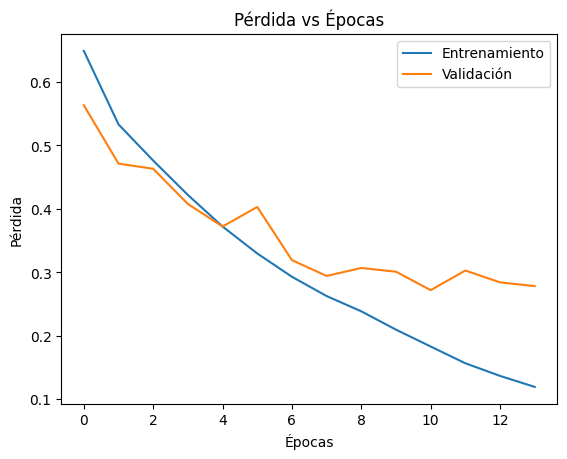

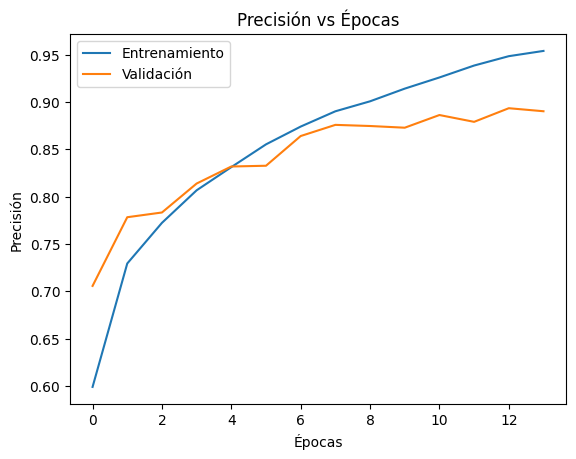

In [11]:
# 1) Gráfica de la pérdida (loss)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# 2) Gráfica de la precisión (accuracy)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [12]:
cnn_model.save('../models/modelo.h5')